In [17]:
import prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [4]:
data = pd.read_csv("./data.csv", sep='\t')
data.drop('Unnamed: 4',axis=1, inplace=True )
print(data.columns)
print(data.head())

Index(['date', 'num_sku', 'pv', 'uv'], dtype='object')
         date   num_sku        pv        uv
0  2019-03-03  194541.0  189561.0  126171.0
1  2019-03-02  123272.0  117885.0   77772.0
2  2019-03-01  103305.0   98978.0   66068.0
3  2019-02-28   89152.0   85853.0   57240.0
4  2019-02-27  104457.0   99293.0   63201.0


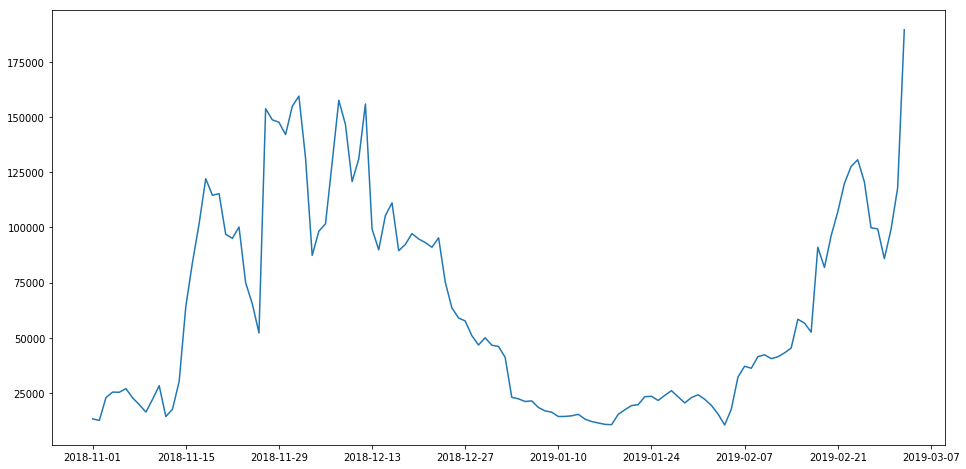

In [7]:
data['date'] = pd.to_datetime(data.date,format='%Y-%m-%d')
data.index = data['date']
plt.figure(figsize=(16,8))
plt.plot(data['pv'], label='shop pv')

In [8]:
def rmse(preds, y):
    result = np.sqrt(np.mean(np.power(preds - y, 2)))
    return result


In [11]:
# 准备样本
df = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'pv'])

for i in range(0,len(df)):
    new_data['date'][i] = df['date'][i]
    new_data['pv'][i] = df['pv'][i]
    
print(new_data.head())
print(new_data.shape)
train = new_data[:93]
valid = new_data[93:] 
train['date'].min(), train['date'].max(), valid['date'].min(), valid['date'].max()

                  date     pv
0  2018-11-01 00:00:00  13257
1  2018-11-02 00:00:00  12544
2  2018-11-03 00:00:00  22891
3  2018-11-04 00:00:00  25380
4  2018-11-05 00:00:00  25308
(123, 2)


(Timestamp('2018-11-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-02-02 00:00:00'),
 Timestamp('2019-03-03 00:00:00'))

rmse:67393.55116933388


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


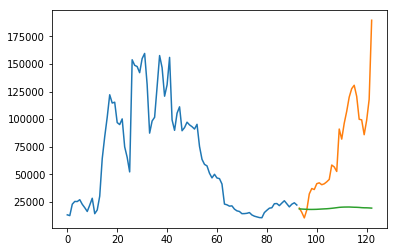

In [14]:
# 移动平均预测
def moving_average(train):
    preds = []
    for i in range(0,30):
        a = train['pv'][len(train)-30+i:].sum() + sum(preds)
        b = a/30.0
        preds.append(b)
    return preds
predict_value = moving_average(train)
error = rmse(valid["pv"].values, predict_value)
print("rmse:{0}".format(error))

valid['pred'] = 0
valid['pred'] = predict_value

plt.plot(train['pv'])

plt.plot(valid[['pv', 'pred']])

In [44]:
#from fbprophet import Prophet

def fb_ts_train(train):
    model = Prophet()
    model.fit(train)
    return model
def ft_ts_predict(model, n):
    preds = model.make_future_dataframe(periods=n)
    
    
# 准备样本
df = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'pv'])

for i in range(0,len(df)):
    new_data['date'][i] = df['date'][i]
    new_data['pv'][i] = df['pv'][i]
new_data.rename(columns={'pv': 'y', 'date': 'ds'}, inplace=True)
print(new_data.head())

                    ds      y
0  2018-11-01 00:00:00  13257
1  2018-11-02 00:00:00  12544
2  2018-11-03 00:00:00  22891
3  2018-11-04 00:00:00  25380
4  2018-11-05 00:00:00  25308


In [19]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [21]:
# 准备样本
df = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'pv'])

for i in range(0,len(df)):
    new_data['date'][i] = df['date'][i]
    new_data['pv'][i] = df['pv'][i]
    
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)
print(new_data.head())

train = new_data[:93].values
valid = new_data[93:].values

               pv
date             
2018-11-01  13257
2018-11-02  12544
2018-11-03  22891
2018-11-04  25380
2018-11-05  25308


In [39]:
def lstm_model_train(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)
    return model
dataset = new_data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
model = lstm_model_train(x_train, y_train)


Epoch 1/10
 - 6s - loss: 0.0027
Epoch 2/10
 - 5s - loss: 0.0016
Epoch 3/10
 - 5s - loss: 0.0011
Epoch 4/10
 - 5s - loss: 0.0013
Epoch 5/10
 - 5s - loss: 0.0010
Epoch 6/10
 - 5s - loss: 0.0010
Epoch 7/10
 - 5s - loss: 8.3479e-04
Epoch 8/10
 - 5s - loss: 0.0011
Epoch 9/10
 - 5s - loss: 9.3050e-04
Epoch 10/10
 - 5s - loss: 8.9322e-04


In [42]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)
error = rmse(preds, valid)
print("rmse:{0}".format(error))

(30, 2)
(123, 1)
(90, 1)
(30, 60)
rmse:pv      33693.549200
pred    32517.135654
dtype: float64


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


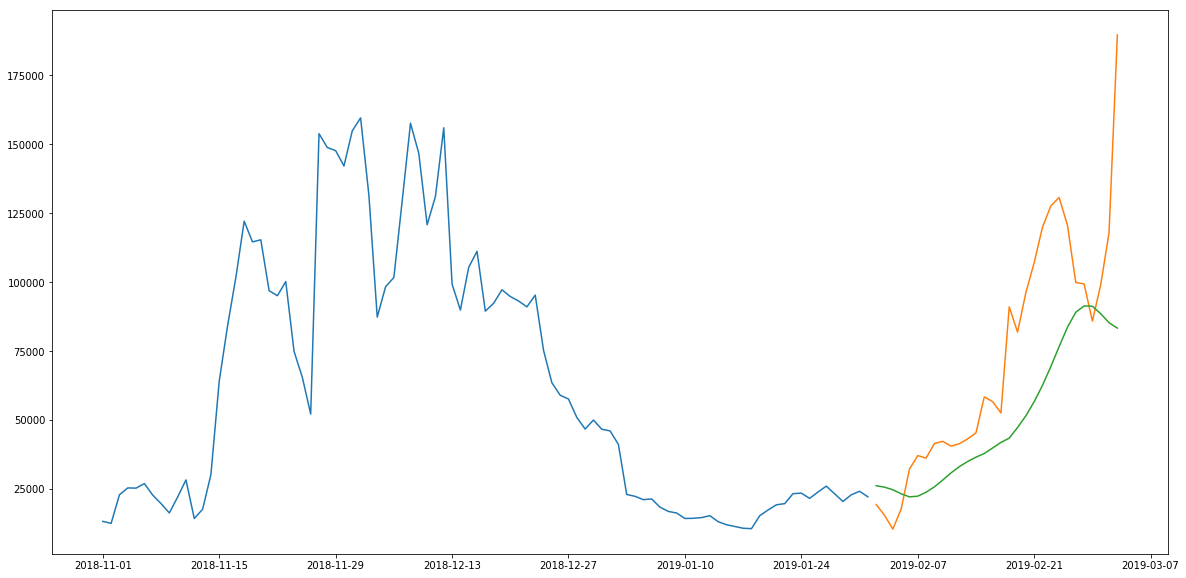

In [43]:
train = new_data[:93]
valid = new_data[93:]
valid['pred'] = preds

plt.plot(train['pv'])
plt.plot(valid[['pv','pred']])